# Импорт библиотек и чтение данных

In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import pickle
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_venn import venn3
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    fbeta_score,
    average_precision_score,
    PrecisionRecallDisplay)
import shap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_parquet('/kaggle/input/fraud-imto/transaction_fraud_data.parquet')
exchange_rates = pd.read_parquet('/kaggle/input/fraud-imto/historical_currency_exchange.parquet')

# Анализ данных

In [45]:
df.head()

,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,is_card_present,device,channel,device_fingerprint,ip_address,is_outside_home_country,is_high_risk_vendor,is_weekend,last_hour_activity,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,False,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,False,False,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,False,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,True,True,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,False,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,False,False,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,False,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,False,False,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,False,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,True,False,False,"{'num_transactions': 218, 'total_amount': 4827...",True


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   transaction_id           object        
 1   customer_id              object        
 2   card_number              int64         
 3   timestamp                datetime64[us]
 4   vendor_category          object        
 5   vendor_type              object        
 6   vendor                   object        
 7   amount                   float64       
 8   currency                 object        
 9   country                  object        
 10  city                     object        
 11  city_size                object        
 12  card_type                object        
 13  is_card_present          bool          
 14  device                   object        
 15  channel                  object        
 16  device_fingerprint       object        
 17  ip_address               ob

In [5]:
exchange_rates.head()

,date,AUD,BRL,CAD,EUR,GBP,JPY,MXN,NGN,RUB,SGD,USD
0,2024-09-30,1.443654,5.434649,1.351196,0.895591,0.747153,142.573268,19.694724,1668.736400,94.133735,1.280156,1
1,2024-10-01,1.442917,5.444170,1.352168,0.897557,0.746956,143.831429,19.667561,1670.694524,92.898519,1.284352,1
2,2024-10-02,1.449505,5.425444,1.348063,0.903056,0.752241,143.806861,19.606748,1669.653006,94.583198,1.286983,1
3,2024-10-03,1.456279,5.442044,1.351451,0.906018,0.754584,146.916773,19.457701,1670.097873,95.655442,1.294391,1
4,2024-10-04,1.460930,5.477788,1.355260,0.906452,0.761891,146.592323,19.363467,1649.763738,94.755337,1.296800,1


In [6]:
min(exchange_rates['date']), max(exchange_rates['date'])

(datetime.date(2024, 9, 30), datetime.date(2024, 10, 30))

In [3]:
df['date'] = df['timestamp'].dt.date

In [8]:
df['is_fraud'].sum() / df.shape[0] 

0.19972818498066347

In [9]:
df.groupby(by='customer_id')['is_fraud'].sum().sort_values(ascending=False)

customer_id
CUST_91730    801
CUST_24836    753
CUST_87928    751
CUST_81009    748
CUST_77434    745
             ... 
CUST_20522    200
CUST_65274    200
CUST_84709    200
CUST_83747    200
CUST_51975    200
Name: is_fraud, Length: 4869, dtype: int64

In [10]:
(df.groupby(by='customer_id')['is_fraud'].sum() / df.groupby(by='customer_id')['is_fraud'].count()).sort_values(ascending=False)

customer_id
CUST_69293    0.200000
CUST_72733    0.200000
CUST_22184    0.200000
CUST_71117    0.200000
CUST_70997    0.200000
                ...   
CUST_43488    0.199207
CUST_62385    0.199207
CUST_94560    0.199207
CUST_84246    0.199203
CUST_40909    0.199203
Name: is_fraud, Length: 4869, dtype: float64

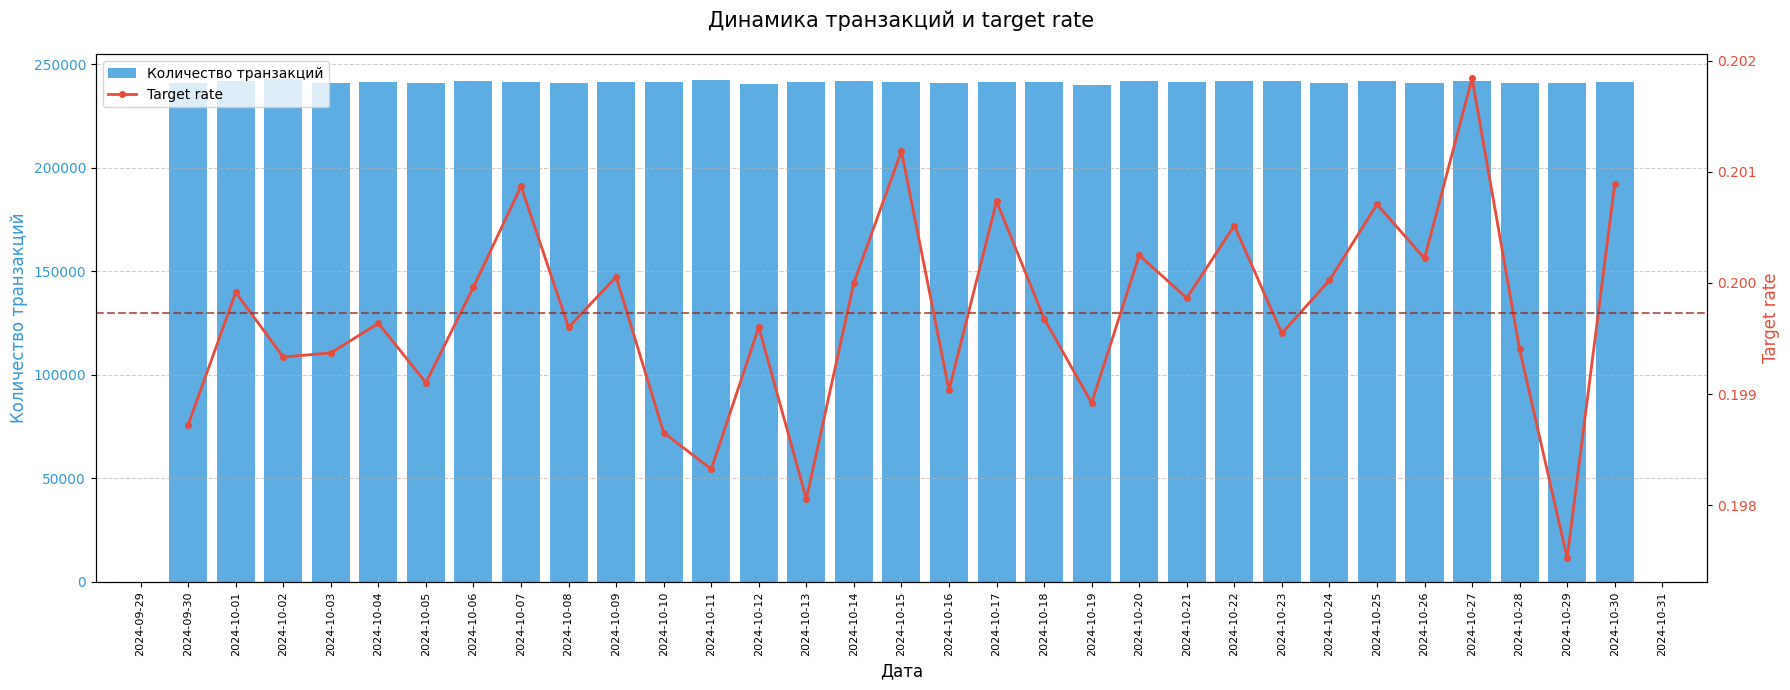

<Figure size 640x480 with 0 Axes>

In [55]:
daily_data = df.groupby('date').agg(
    transaction_count=('transaction_id', 'count'),
    fraud_rate=('is_fraud', 'mean')
).reset_index()

full_date_range = pd.date_range(
    start=daily_data['date'].min(),
    end=daily_data['date'].max(),
    freq='D'
)

daily_data = daily_data.set_index('date').reindex(full_date_range).fillna({
    'transaction_count': 0,
    'fraud_rate': 0  
}).reset_index().rename(columns={'index': 'date'})

fig, ax1 = plt.subplots(figsize=(18, 7))

ax1.bar(
    daily_data['date'], 
    daily_data['transaction_count'], 
    color='#3498DB', 
    alpha=0.8, 
    label='Количество транзакций'
)
ax1.set_xlabel('Дата', fontsize=12)
ax1.set_ylabel('Количество транзакций', color='#3498DB', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#3498DB')
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(
    daily_data['date'], 
    daily_data['fraud_rate'],
    color='#E74C3C', 
    marker='o',
    markersize=4,
    linewidth=2,
    label='Target rate'
)
ax2.set_ylabel('Target rate', color='#E74C3C', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#E74C3C')

ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.setp(ax1.xaxis.get_ticklabels(), 
         rotation=90,
         ha='center',
         fontsize=8)

avg_fraud = df['is_fraud'].mean()
ax2.axhline(y=avg_fraud, color='#922B21', linestyle='--', alpha=0.7)

plt.title('Динамика транзакций и target rate', fontsize=15, pad=20)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig("/kaggle/working/tr_dynamic.png")

### Генерация новых фичей и преобразование фичей связанных с деньгами

In [4]:
#парсинг составной фичи
df['last_hour_num_transactions'] = df['last_hour_activity'].apply(lambda x: x['num_transactions'])
df['last_hour_total_amount'] = df['last_hour_activity'].apply(lambda x: x['total_amount'])
df['last_hour_unique_merchants'] = df['last_hour_activity'].apply(lambda x: x['unique_merchants'])
df['last_hour_unique_countries'] = df['last_hour_activity'].apply(lambda x: x['unique_countries'])
df['last_hour_max_single_amount'] = df['last_hour_activity'].apply(lambda x: x['max_single_amount'])

In [5]:
exchange_rates.columns

Index(['date', 'AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'JPY', 'MXN', 'NGN', 'RUB',
       'SGD', 'USD'],
      dtype='object')

In [6]:
#приведение amount к USD
tmp = exchange_rates.melt(
    id_vars=['date'],
    value_vars=['AUD', 'BRL', 'CAD', 'EUR', 'GBP', 'JPY', 'MXN', 'NGN', 'RUB', 'SGD', 'USD'],
    var_name='currency',
    value_name='exchange_rate'
)
tmp = pd.merge(df, tmp, on=['date', 'currency'], how='left')

df['amount'] = tmp['amount'] * tmp['exchange_rate']
df['last_hour_total_amount'] = tmp['last_hour_total_amount'] * tmp['exchange_rate']
df['last_hour_max_single_amount'] = tmp['last_hour_max_single_amount'] * tmp['exchange_rate']

In [7]:
#Генерация новых фичей
#Аномалия суммы (отклонение от среднего клиента)
df['amount_anomaly'] = df.groupby('customer_id')['amount'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-5)
)

# Географический риск (страны с высоким fraud_rate)
country_risk = df.groupby('country')['is_fraud'].mean()
df['country_risk'] = df['country'].map(country_risk)

In [8]:
info_cols = ['transaction_id', 'customer_id', 'card_number', 'timestamp', 'date', 'last_hour_activity', 'device_fingerprint', 'ip_address']
long_list = [col for col in list(df.columns) if col not in info_cols + ['is_fraud']]
df[df[long_list].select_dtypes(include=['bool']).columns] = df[long_list].select_dtypes(include=['bool']).astype('int')
cat_feats = list(df[long_list].select_dtypes(include=['object']).columns)
target = 'is_fraud'

In [12]:
amount_check = df[['amount', target]].sort_values(by='amount', ascending=False)

In [13]:
tmp = amount_check[amount_check['amount'] > amount_check['amount'].median()]
tmp['is_fraud'].sum(), df['is_fraud'].sum(), tmp['is_fraud'].sum() / df['is_fraud'].sum()

(1093565, 1494719, 0.7316191203831623)

In [14]:
tmp = amount_check[amount_check['amount'] < amount_check['amount'].median()]
tmp['is_fraud'].sum(), df['is_fraud'].sum(), tmp['is_fraud'].sum() / df['is_fraud'].sum()

(401154, 1494719, 0.26838087961683765)

In [15]:
percs = df['amount'].describe(percentiles=[.25, .5, .75, .80, .85, .90, .95, .98, .99])

In [16]:
tmp = amount_check[amount_check['amount'] < percs.loc['50%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (3741883, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.26838087961683765
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.10720645193876986


In [17]:
tmp = amount_check[amount_check['amount'] > percs.loc['75%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (1870942, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.3198694871745124
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.2555477401223555


In [18]:
tmp = amount_check[amount_check['amount'] > percs.loc['90%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (748377, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.14196715235438903
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.28354826511236986


In [19]:
tmp = amount_check[amount_check['amount'] > percs.loc['99%']]
print('Количество наблюдений по катофу:', tmp.shape)
print('Количество фрауд операций по отоношению ко всем фрауд операциям:',tmp['is_fraud'].sum() / df['is_fraud'].sum())
print('Количество фрауд операций по отоношению количеству наблюдений по катофу:',tmp['is_fraud'].sum() / tmp.shape[0])

Количество наблюдений по катофу: (74838, 2)
Количество фрауд операций по отоношению ко всем фрауд операциям: 0.04062904131144382
Количество фрауд операций по отоношению количеству наблюдений по катофу: 0.811472781207408


In [20]:
scam_df = df[df['is_fraud'] == True]
unscam_df = df[df['is_fraud'] == False]

In [21]:
print(scam_df['amount'].mean())
print(unscam_df['amount'].mean())
print(scam_df['amount'].mean() / unscam_df['amount'].mean())

154411983.05383274
34829320.74042159
4.433390596521971


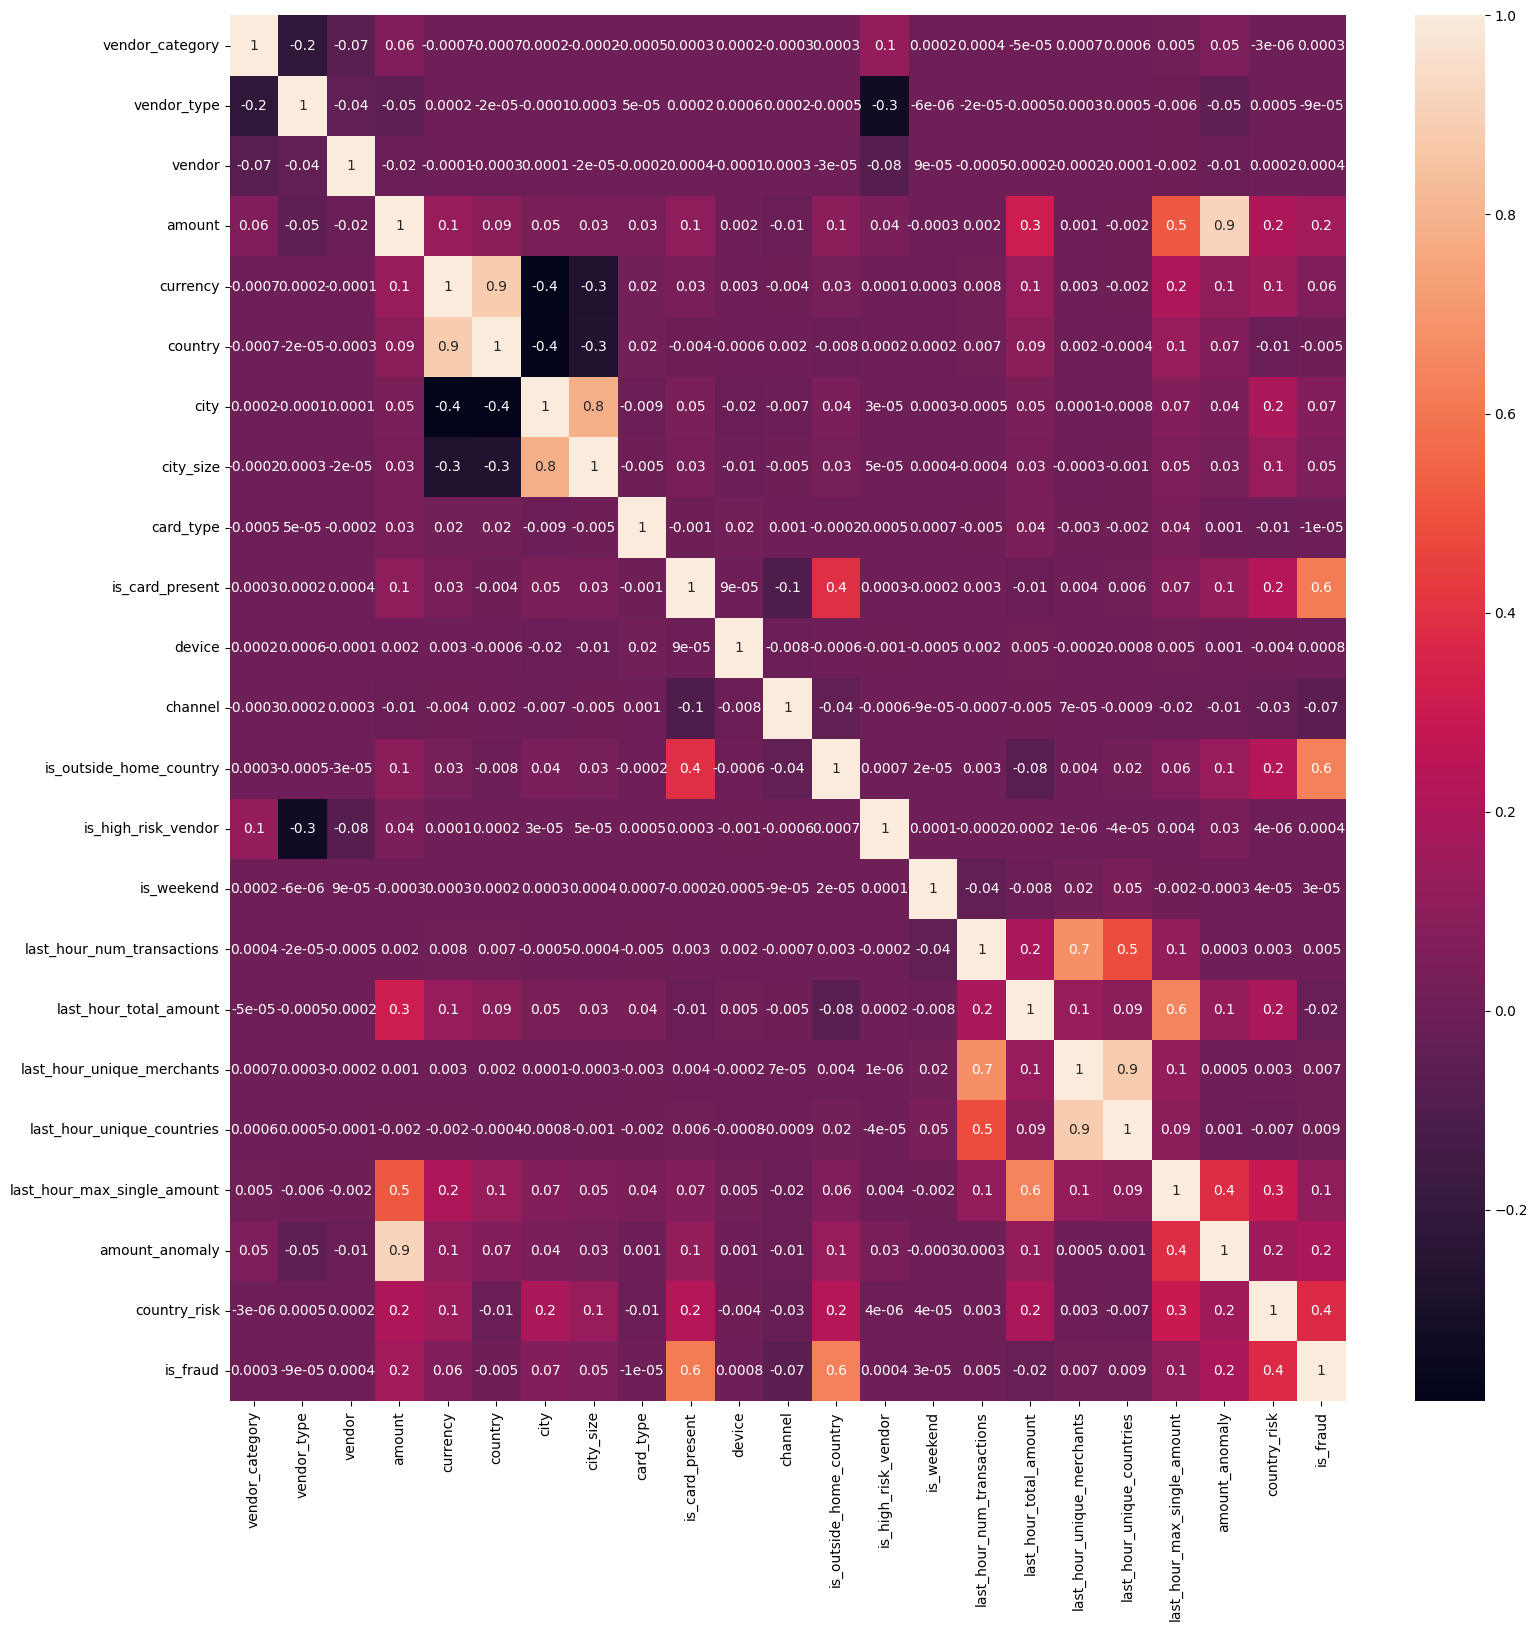

<Figure size 640x480 with 0 Axes>

In [56]:
figsize = (18, 18)

fig, ax = plt.subplots(figsize=figsize)
# feats = list(df.select_dtypes(exclude='object').columns)
# feats.remove('timestamp')
# feats.remove('card_number')
hmap = sns.heatmap(tmp_df[long_list + [target]].corr(), annot = True, fmt='.1g', ax=ax)
plt.show()
plt.savefig("/kaggle/working/corr_heatmap.png")

In [85]:
scam_df['last_hour_num_transactions'].mean(), unscam_df['last_hour_num_transactions'].mean()

(412.67047920043836, 408.26253308748454)

In [9]:
tmp = df[df['is_card_present'] == 1]
print(f"{tmp[tmp['is_outside_home_country'] == 1]['is_fraud'].sum() / tmp[tmp['is_outside_home_country'] == 1].shape[0] * 100}% мошеннических транзакций при условии, is_card_present == 1 и is_outside_home_country == 1")

100.0% мошеннических транзакций при условии, is_card_present == 1 и is_outside_home_country == 1


In [14]:
tmp = tmp[tmp['is_outside_home_country'] == 1]
tmp.groupby(by='country')['country'].count().sort_values(ascending=False)

country
Mexico       119732
Russia       119671
Brazil       119410
Nigeria      117648
Australia     15246
Japan         15060
Canada        14964
USA           14929
Germany       14884
UK            14859
France        14732
Singapore     14676
Name: country, dtype: int64

In [15]:
long_list

['vendor_category',
 'vendor_type',
 'vendor',
 'amount',
 'currency',
 'country',
 'city',
 'city_size',
 'card_type',
 'is_card_present',
 'device',
 'channel',
 'is_outside_home_country',
 'is_high_risk_vendor',
 'is_weekend',
 'last_hour_num_transactions',
 'last_hour_total_amount',
 'last_hour_unique_merchants',
 'last_hour_unique_countries',
 'last_hour_max_single_amount',
 'amount_anomaly',
 'country_risk']

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


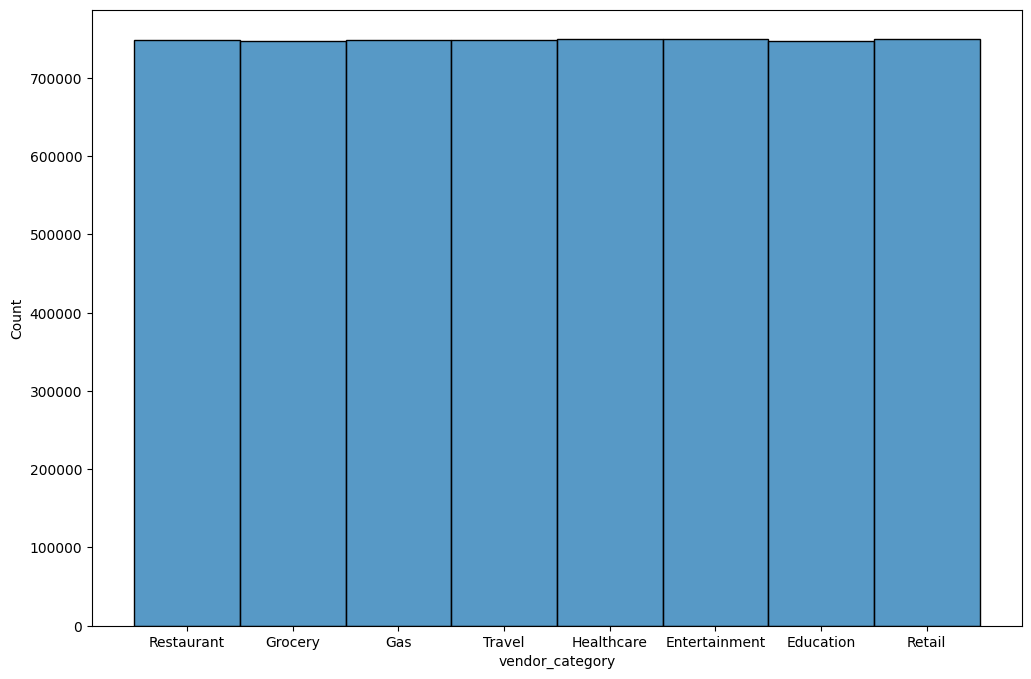

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


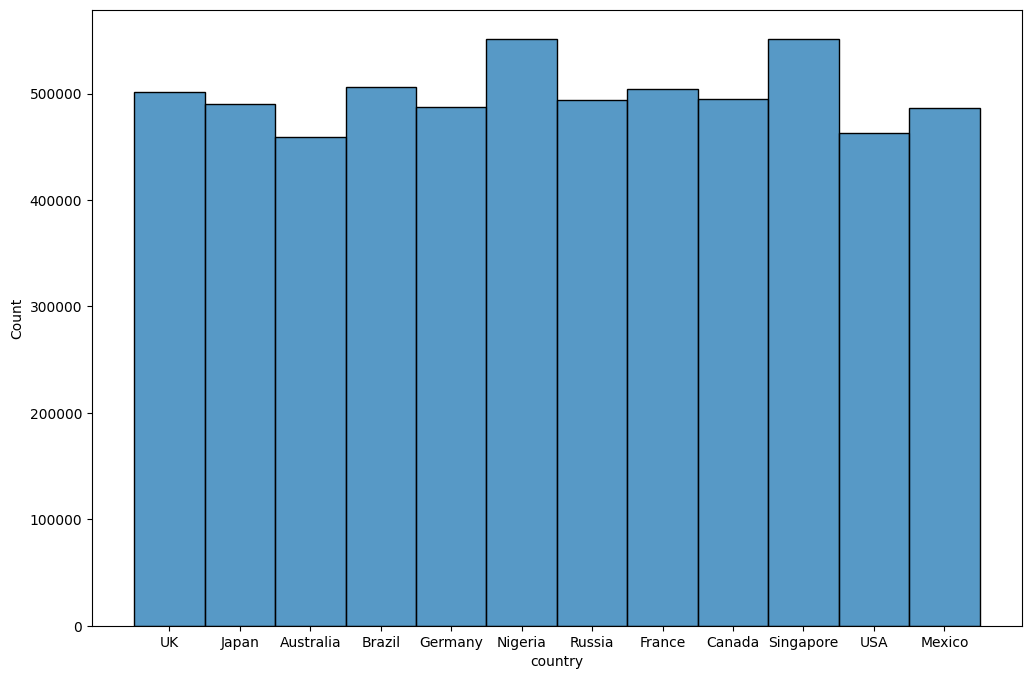

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


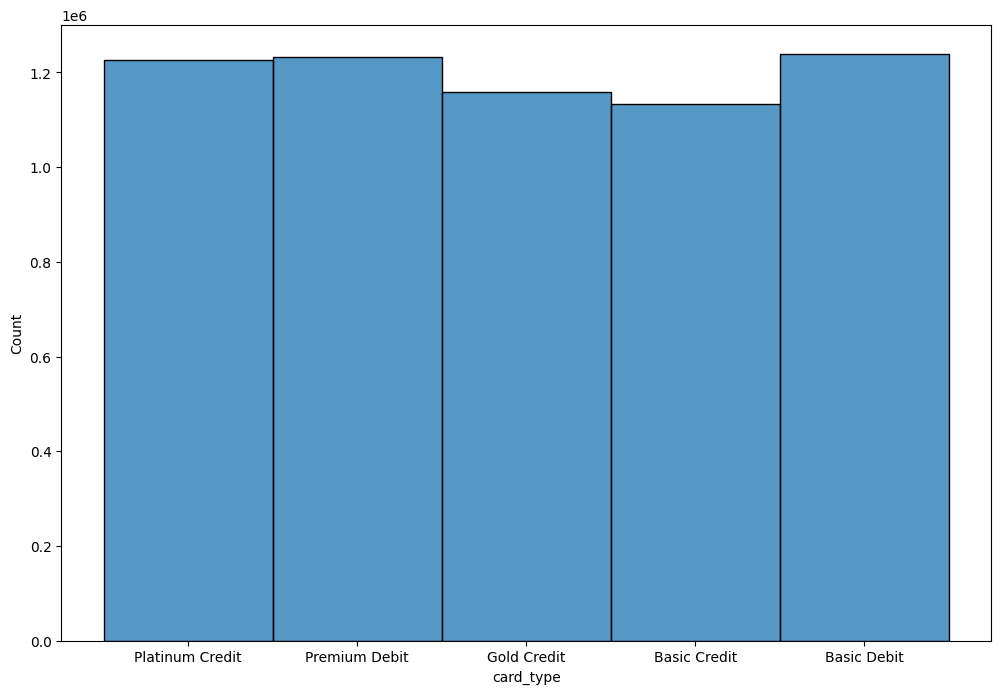

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


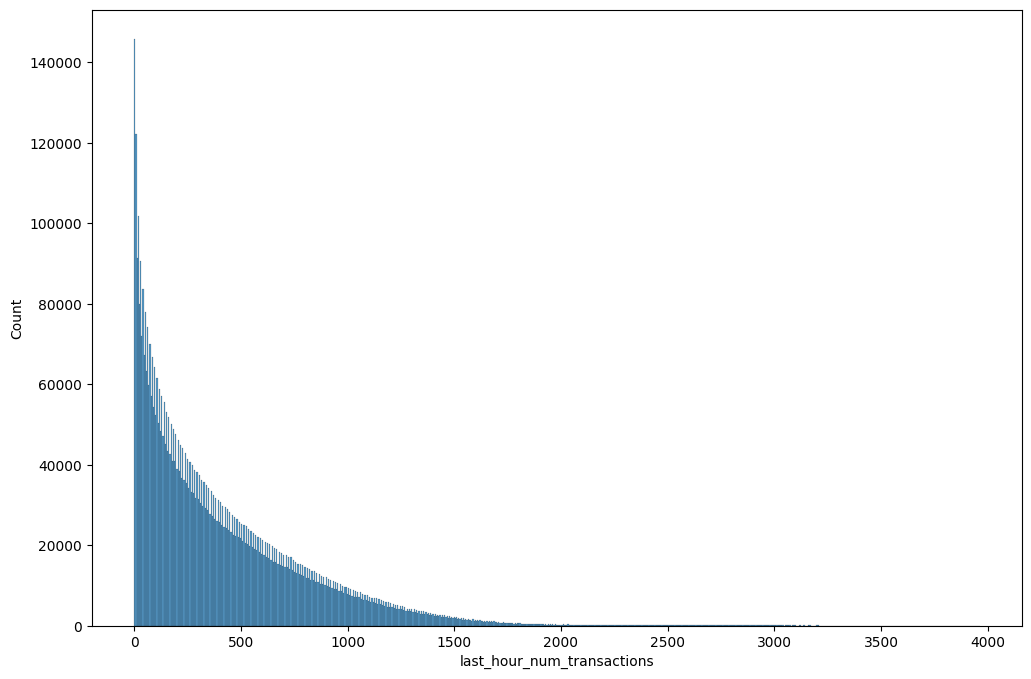

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


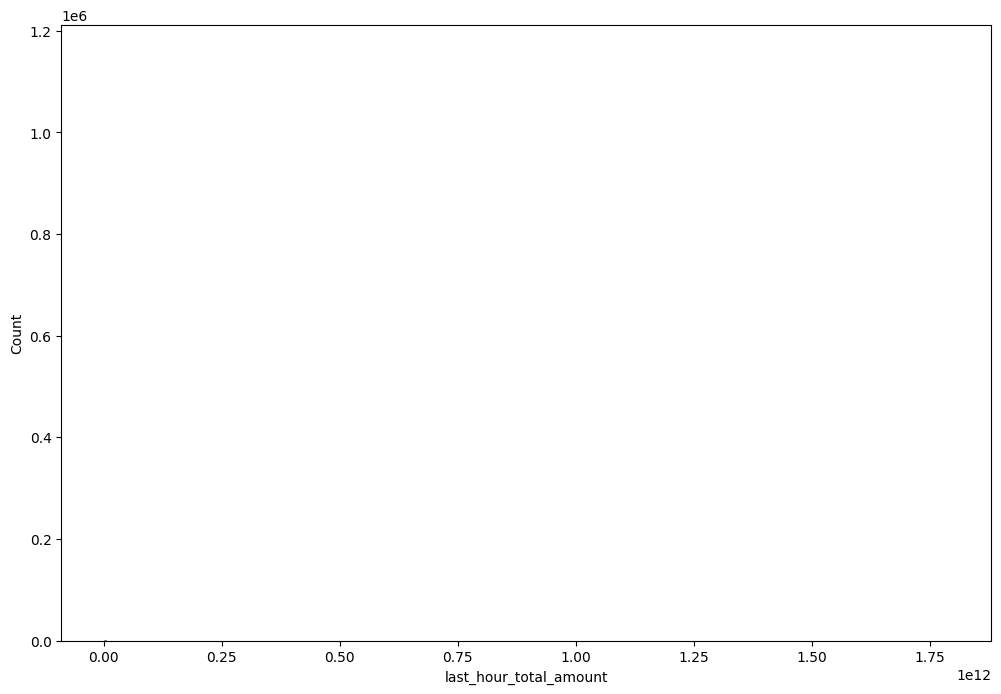

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


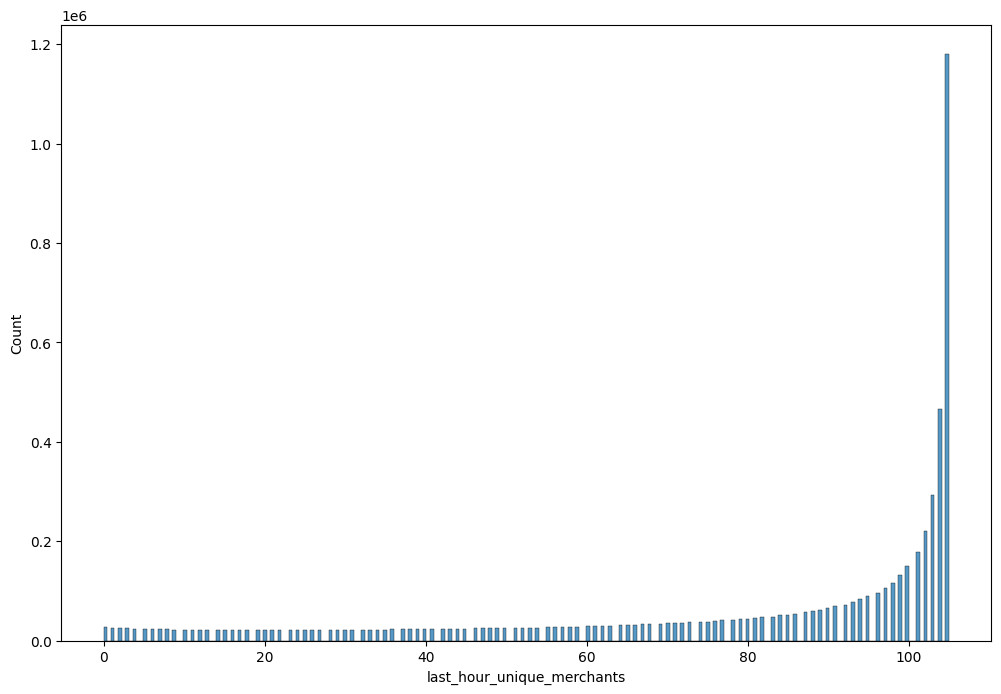

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


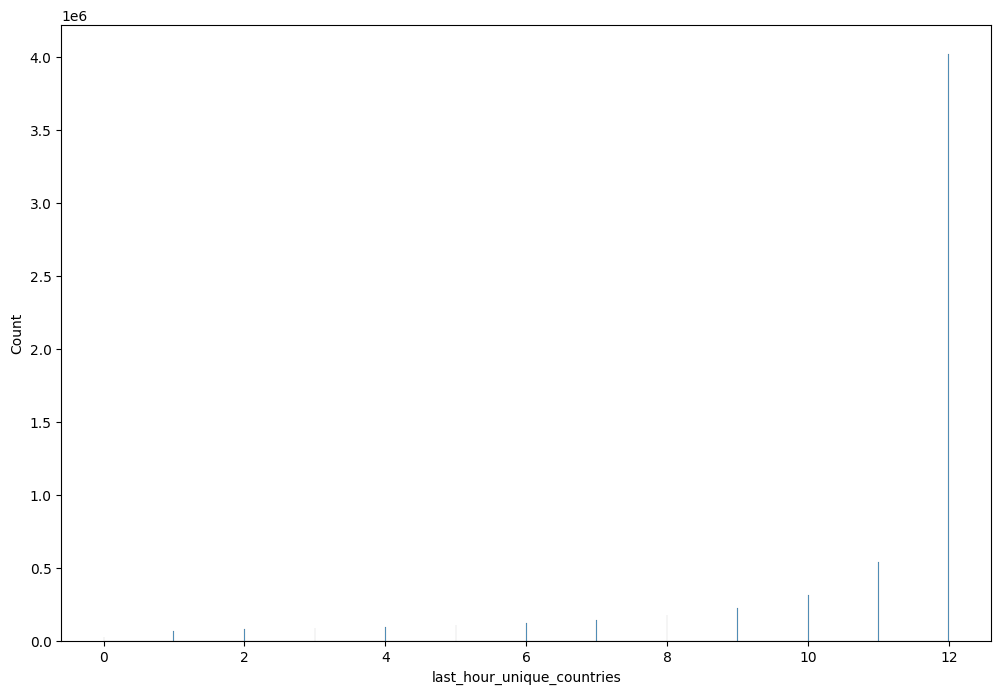

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


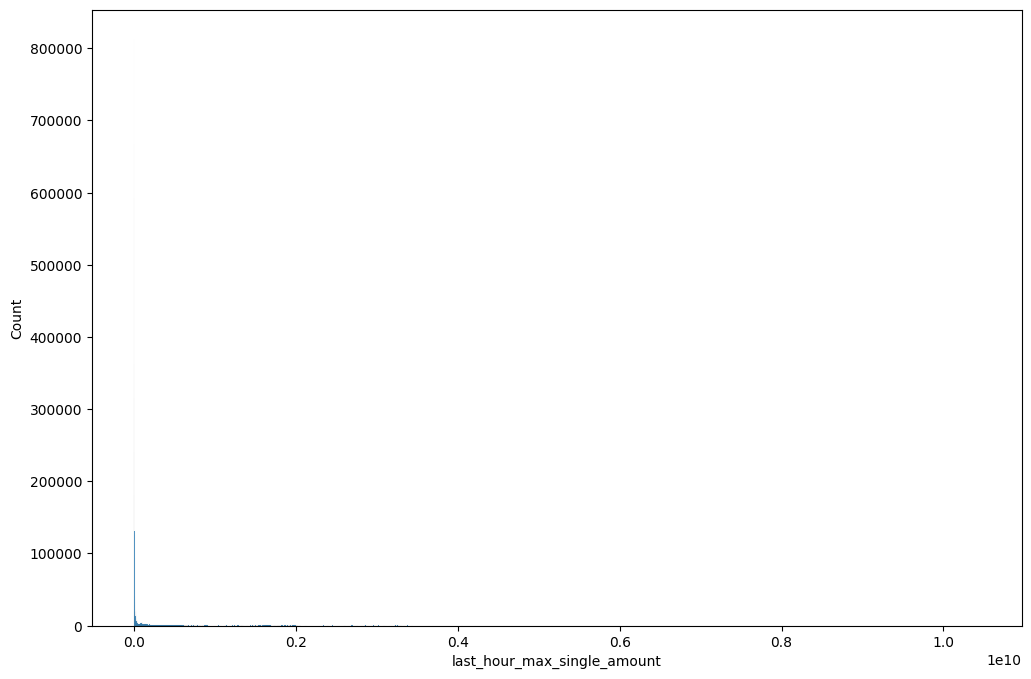

In [23]:
for feat in ['vendor_category', 'country', 'card_type', 'last_hour_num_transactions', 'last_hour_total_amount', 'last_hour_unique_merchants', 'last_hour_unique_countries', 'last_hour_max_single_amount']:
    plt.figure(figsize=(12, 8))
    sns.histplot(unscam_df[feat])
    plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


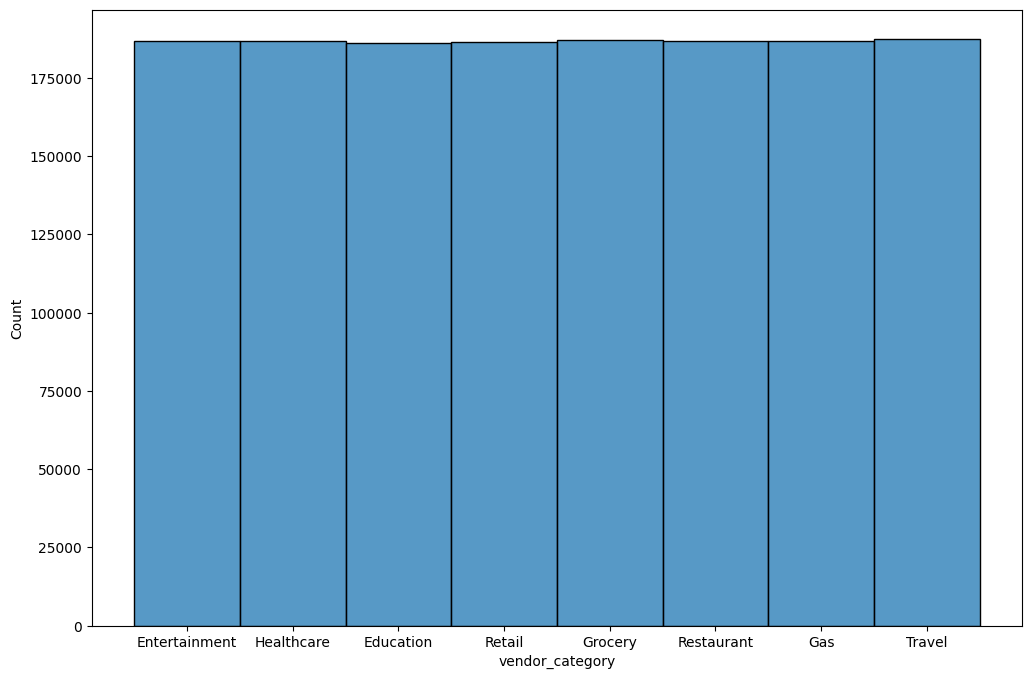

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


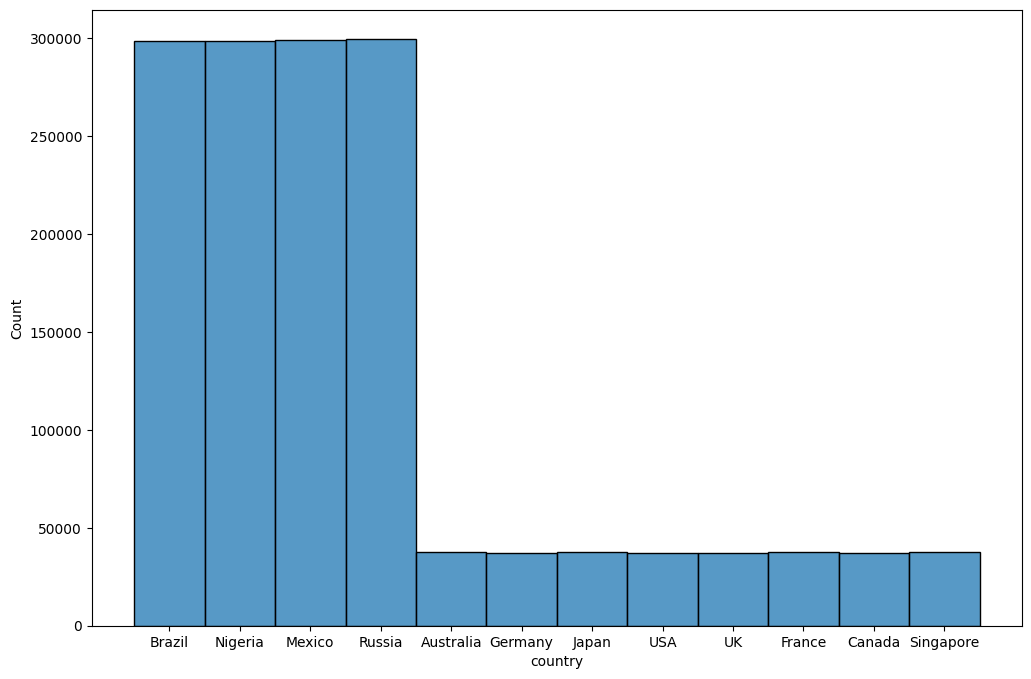

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


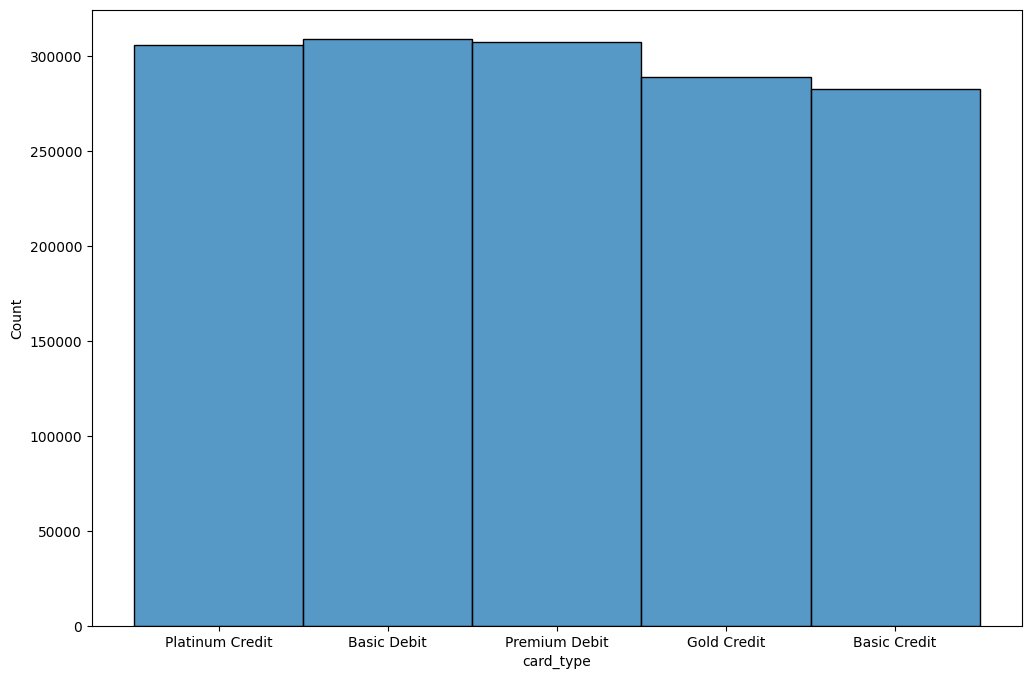

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


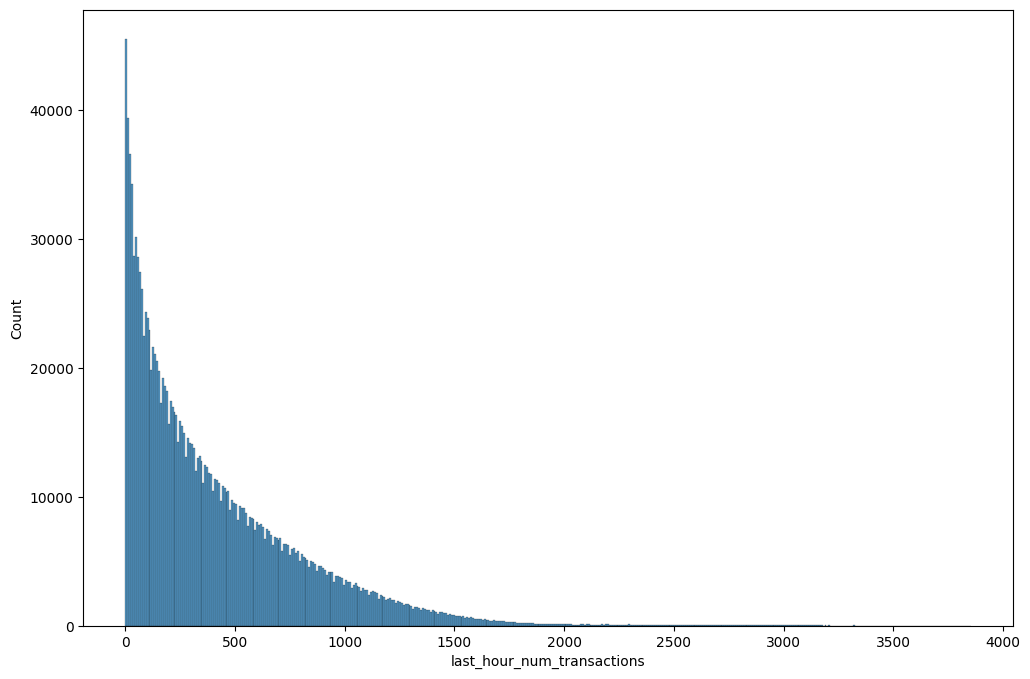

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


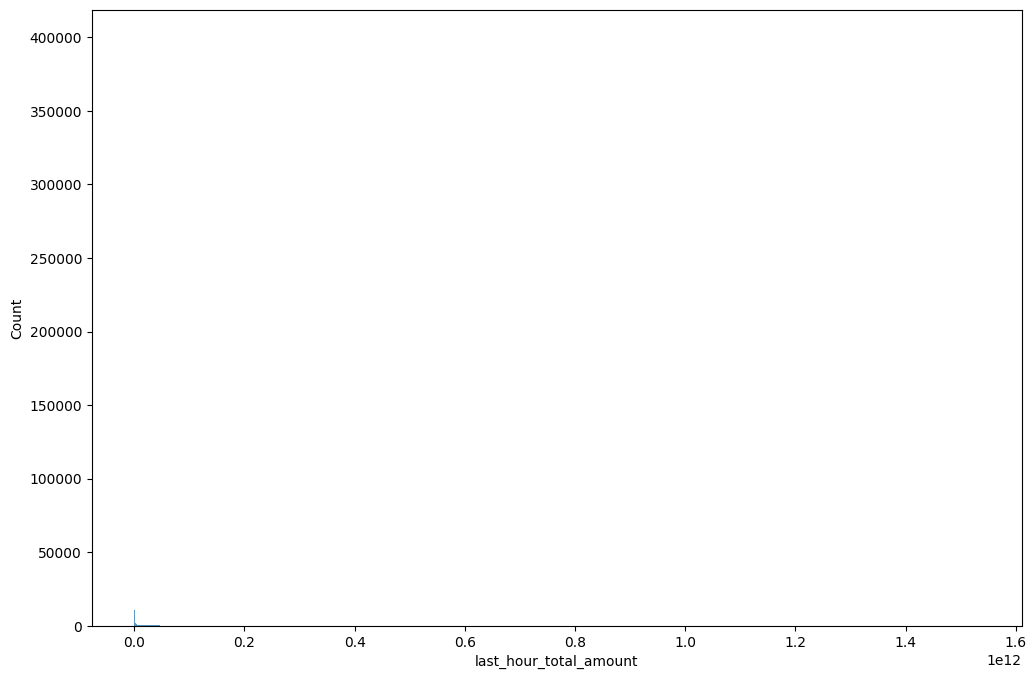

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


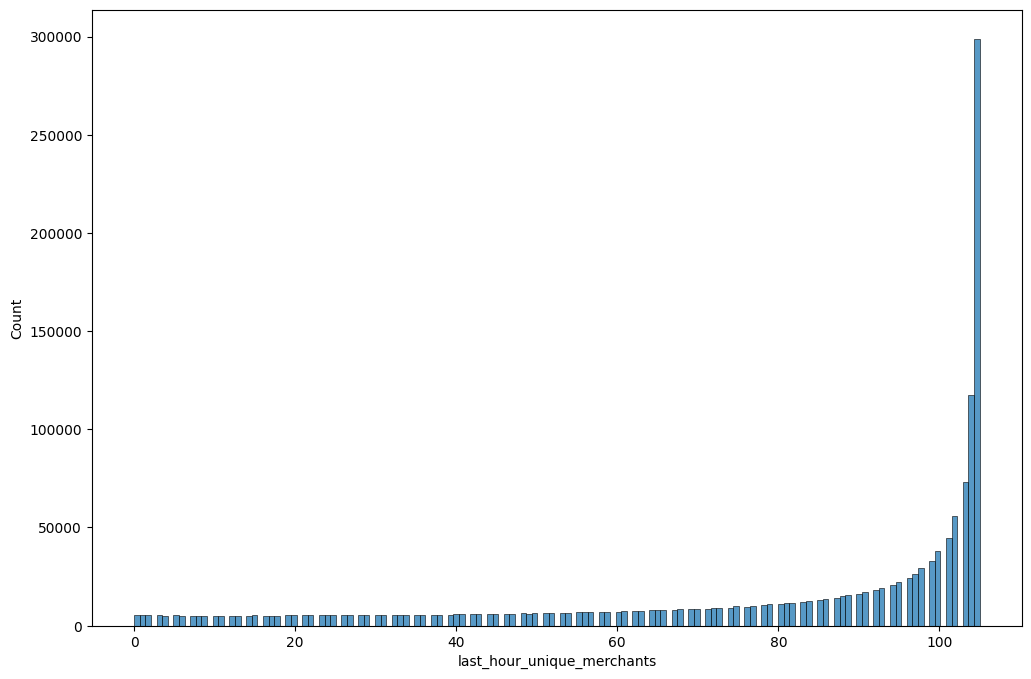

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


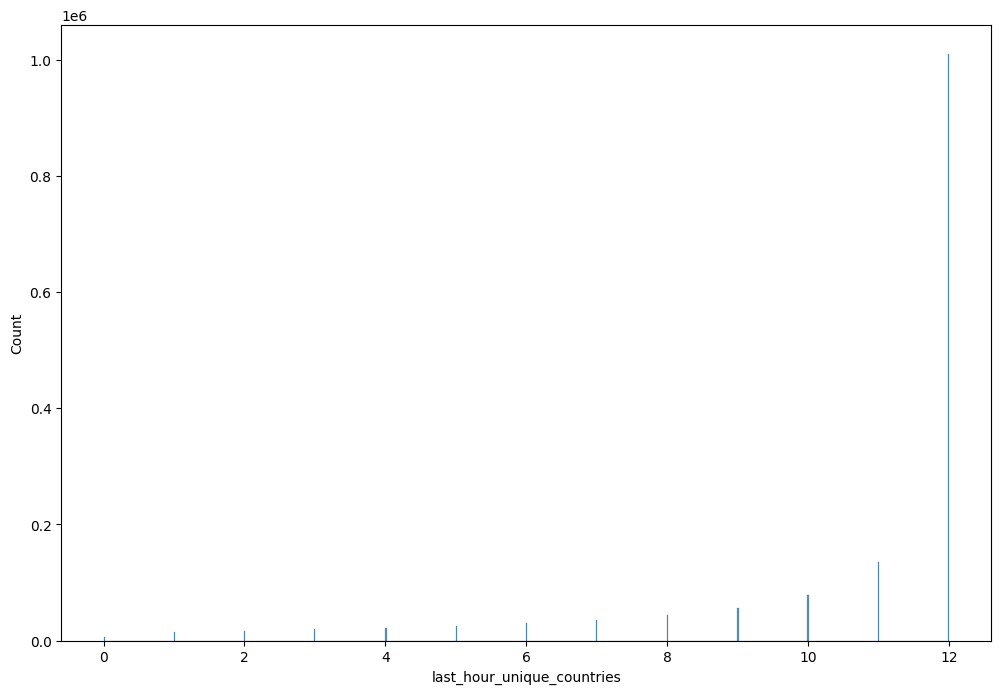

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


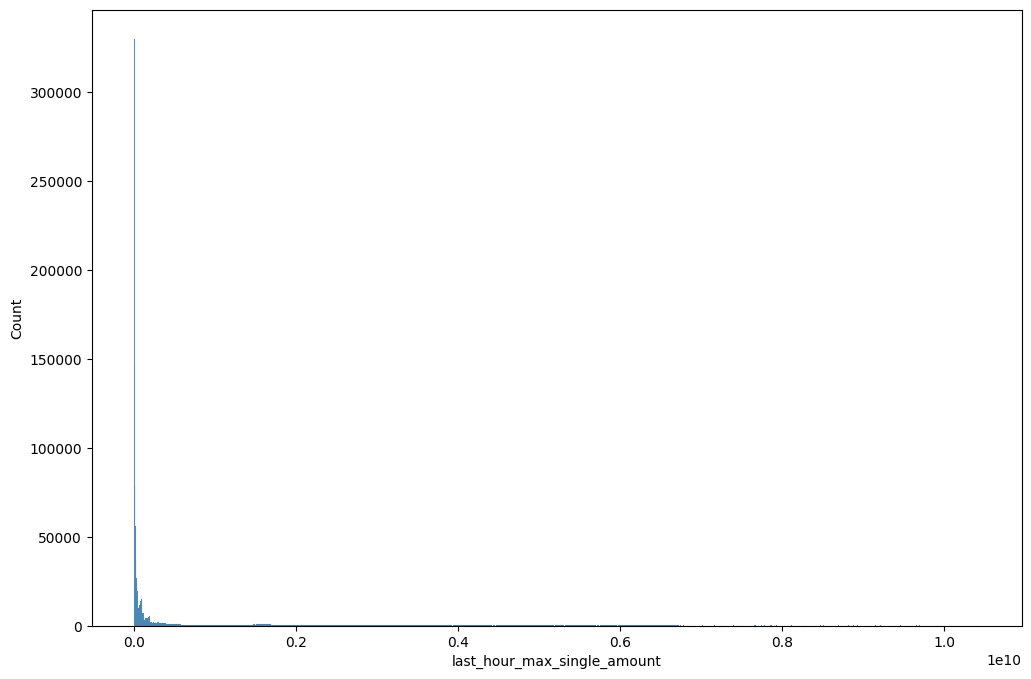

In [21]:
for feat in ['vendor_category', 'country', 'card_type', 'last_hour_num_transactions', 'last_hour_total_amount', 'last_hour_unique_merchants', 'last_hour_unique_countries', 'last_hour_max_single_amount']:
    plt.figure(figsize=(12, 8))
    sns.histplot(scam_df[feat])
    plt.show()

In [24]:
df['last_hour_max_single_amount'].describe(percentiles=[0.15, 0.35, 0.5, 0.65, 0.75, 0.85, 0.9, 0.95])

count    7.483766e+06
mean     3.802098e+08
std      1.209458e+09
min      1.114304e-02
15%      8.435908e+05
35%      2.055808e+06
50%      4.640557e+06
65%      2.007556e+07
75%      8.785473e+07
85%      2.960890e+08
90%      9.955216e+08
95%      2.565947e+09
max      1.044711e+10
Name: last_hour_max_single_amount, dtype: float64

# Построение модели

### Подготовка данных для обучения

In [27]:
#Разделение выборок на train/valid/out-of-sample. Деление будет происходить по клиентам 

customers = df['customer_id'].unique()
cust_train, cust_oos, _, _ = train_test_split(customers, customers, test_size=0.3, random_state=42, shuffle=True)

cust_train, cust_val, _, _ = train_test_split(cust_train, cust_train, test_size=0.3, random_state=42, shuffle=True)

In [28]:
len(cust_train), len(cust_val), len(cust_oos)

(2385, 1023, 1461)

In [29]:
train = df[df['customer_id'].isin(cust_train)]
val = df[df['customer_id'].isin(cust_val)]
oos = df[df['customer_id'].isin(cust_oos)]
train.shape, val.shape, oos.shape

((3647393, 31), (1588830, 31), (2247543, 31))

In [19]:
train[target].sum() / train.shape[0], val[target].sum() / val.shape[0], oos[target].sum() / oos.shape[0]

(0.19972923126189035, 0.19973502514428856, 0.19972165159910177)

In [55]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(train[cat_feats])
train[cat_feats] = enc.transform(train[cat_feats])
val[cat_feats] = enc.transform(val[cat_feats])
oos[cat_feats] = enc.transform(oos[cat_feats])
tmp_df = df.copy()
tmp_df[cat_feats] = enc.transform(df[cat_feats])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Проверка качества разбиения

In [60]:
data = [train, val, oos]
for df, name in zip(data, ['train', 'valid', 'oos']):
    print(f"Колиество дубликатов в выборке {name} = {train.duplicated(subset=['transaction_id', 'customer_id', 'card_number', 'timestamp']).sum()}")

Колиество дубликатов в выборке train = 0
Колиество дубликатов в выборке valid = 0
Колиество дубликатов в выборке oos = 0


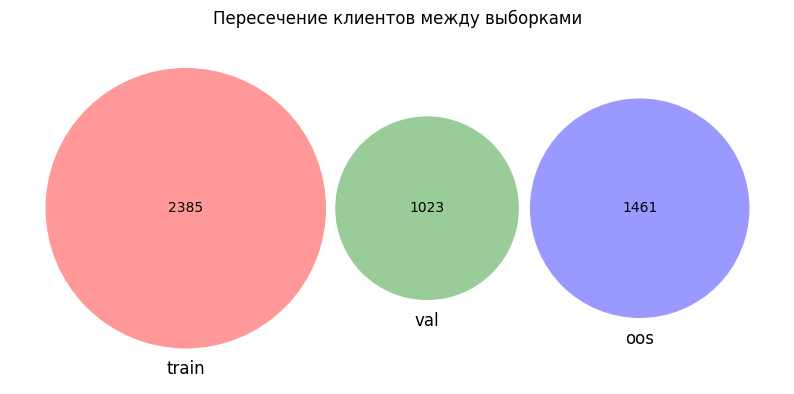

In [65]:
plt.figure(figsize=(10, 7))
venn3(
    subsets=[train, val, oos],
    set_labels=('train', 'val', 'oos')
)
plt.title('Пересечение клиентов между выборками')
plt.savefig("/kaggle/working/intersection.png")

### Построение модели, оптимизация гиперпараметров

In [29]:
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
        'num_leaves': trial.suggest_int('num_leaves', 63, 255),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    model = LGBMClassifier(**params)
    
    model.fit(train[long_list], train[target], eval_set=(val[long_list], val[target]))
    preds = model.predict_proba(val[long_list])[:, 1]
    
    metric = average_precision_score(val[target], preds)

    return metric

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-08-05 07:58:18,872] A new study created in memory with name: no-name-c056bf80-4319-4322-8141-ada6627020fa
[I 2025-08-05 07:59:37,090] Trial 0 finished with value: 0.9722818258358322 and parameters: {'num_leaves': 193, 'max_depth': 7, 'learning_rate': 0.03659306585992244, 'n_estimators': 165, 'subsample': 0.8328454131748089, 'reg_alpha': 0.25746046452409715, 'reg_lambda': 0.7418382479486014, 'min_child_samples': 42}. Best is trial 0 with value: 0.9722818258358322.
[I 2025-08-05 08:00:31,036] Trial 1 finished with value: 0.9735622508329546 and parameters: {'num_leaves': 188, 'max_depth': 5, 'learning_rate': 0.0846949856981491, 'n_estimators': 135, 'subsample': 0.6689314051968023, 'reg_alpha': 0.15942349078432963, 'reg_lambda': 0.2886661064645557, 'min_child_samples': 75}. Best is trial 1 with value: 0.9735622508329546.
[I 2025-08-05 08:03:16,837] Trial 2 finished with value: 0.9648966767117868 and parameters: {'num_leaves': 82, 'max_depth': 4, 'learning_rate': 0.026280779862674, 

In [33]:
study.best_trial

FrozenTrial(number=4, state=1, values=[0.9888786569658724], datetime_start=datetime.datetime(2025, 8, 5, 8, 4, 0, 37480), datetime_complete=datetime.datetime(2025, 8, 5, 8, 6, 24, 48072), params={'num_leaves': 241, 'max_depth': 7, 'learning_rate': 0.08789776092258433, 'n_estimators': 280, 'subsample': 0.8402493124858896, 'reg_alpha': 0.5067039210294677, 'reg_lambda': 0.4727770776270962, 'min_child_samples': 87}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=255, log=False, low=63, step=1), 'max_depth': IntDistribution(high=8, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'min_child_sam

In [34]:
params = study.best_params
params['random_state'] = 42
params['eval_metric'] = 'F1'
params['verbose'] = -1
params['early_stopping_rounds'] = 50


In [35]:
model = LGBMClassifier(**params)
    
model.fit(train[long_list], train[target], eval_set=(val[long_list], val[target]))
preds = model.predict_proba(oos[long_list])[:, 1]
    
metric = average_precision_score(oos[target], preds)
print('pr-auc', metric)
metric = 2*roc_auc_score(oos[target], preds) - 1
print('gini', metric)

pr-auc 0.9888478150954967
gini 0.9920623496505718


In [36]:
with open('/kaggle/working/model_long_list.pickle', 'wb') as f:
    pickle.dump(model, f)

<Axes: xlabel='feature importance', ylabel='feature name'>

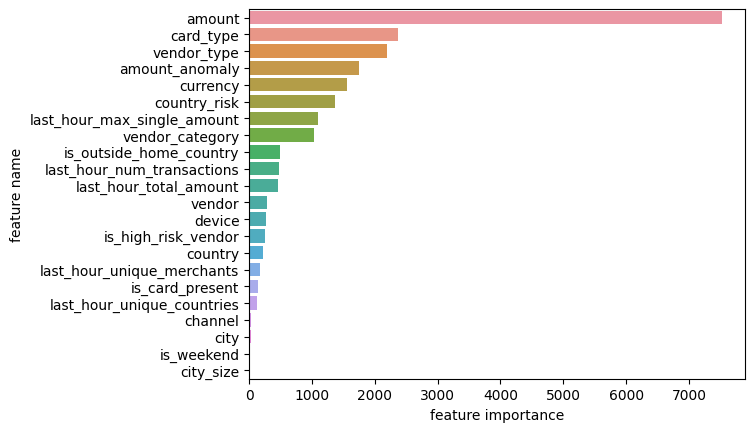

In [37]:
feature_importance = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': model.feature_name_}).sort_values(by='feature importance', ascending=False)
sns.barplot(feature_importance, y='feature name', x='feature importance')

In [38]:
#далее построим модель на шорт листе, удалив 40% признаков
feature_importance = feature_importance['feature name'].to_list()
short_list = feature_importance[:13]

In [39]:
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
        'num_leaves': trial.suggest_int('num_leaves', 63, 255),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    model = LGBMClassifier(**params)
    
    model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
    preds = model.predict_proba(val[short_list])[:, 1]
    
    metric = average_precision_score(val[target], preds)

    return metric

In [40]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-08-05 08:14:37,538] A new study created in memory with name: no-name-74a0e7d0-6047-425a-8d33-529d2653a375
[I 2025-08-05 08:15:17,843] Trial 0 finished with value: 0.9763478169833459 and parameters: {'num_leaves': 104, 'max_depth': 7, 'learning_rate': 0.0705693336253742, 'n_estimators': 89, 'subsample': 0.6647237524520517, 'reg_alpha': 0.4059189635696832, 'reg_lambda': 0.21630907024306778, 'min_child_samples': 41}. Best is trial 0 with value: 0.9763478169833459.
[I 2025-08-05 08:16:04,654] Trial 1 finished with value: 0.8807102971089926 and parameters: {'num_leaves': 128, 'max_depth': 4, 'learning_rate': 0.01102691514725684, 'n_estimators': 170, 'subsample': 0.6852102717831284, 'reg_alpha': 0.8948462681632756, 'reg_lambda': 2.12942761865189, 'min_child_samples': 98}. Best is trial 0 with value: 0.9763478169833459.
[I 2025-08-05 08:16:33,384] Trial 2 finished with value: 0.8862574549349879 and parameters: {'num_leaves': 198, 'max_depth': 4, 'learning_rate': 0.020640922156209097, 

In [41]:
study.best_trial

FrozenTrial(number=8, state=1, values=[0.9889218346627204], datetime_start=datetime.datetime(2025, 8, 5, 8, 21, 48, 707135), datetime_complete=datetime.datetime(2025, 8, 5, 8, 25, 25, 88489), params={'num_leaves': 251, 'max_depth': 8, 'learning_rate': 0.038314997752037616, 'n_estimators': 464, 'subsample': 0.8404512007940845, 'reg_alpha': 5.222179938811209, 'reg_lambda': 0.15926970390088038, 'min_child_samples': 61}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=255, log=False, low=63, step=1), 'max_depth': IntDistribution(high=8, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'min_chil

In [42]:
params = study.best_params
params['random_state'] = 42
params['eval_metric'] = 'F1'
params['verbose'] = -1
params['early_stopping_rounds'] = 50

In [43]:
model = LGBMClassifier(**params)

model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
preds = model.predict_proba(oos[short_list])[:, 1]
    
metric = average_precision_score(oos[target], preds)
print('pr-auc', metric)
metric = 2*roc_auc_score(oos[target], preds) - 1
print('gini', metric)

pr-auc 0.988904205451009
gini 0.9921542994460739


In [44]:
with open('/kaggle/working/model_short_list.pickle', 'wb') as f:
    pickle.dump(model, f)

<Axes: xlabel='feature importance', ylabel='feature name'>

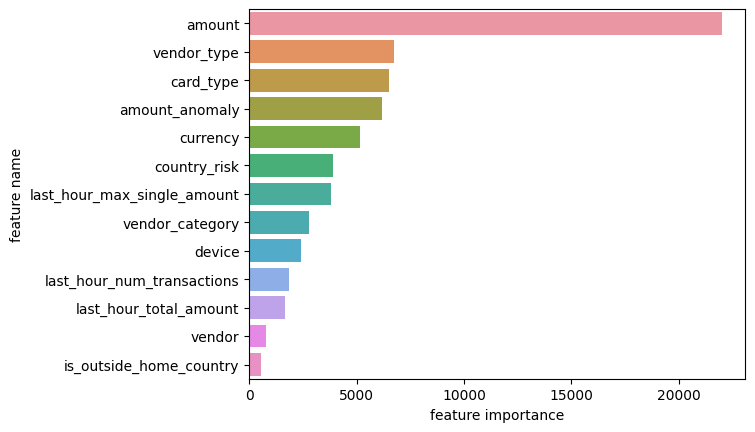

In [45]:
feature_importance = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': model.feature_name_}).sort_values(by='feature importance', ascending=False)
sns.barplot(feature_importance, y='feature name', x='feature importance')

In [46]:
feature_importance = feature_importance['feature name'].to_list()
short_list = feature_importance[:4]

In [47]:
def objective(trial):
    params = {
        'random_state': 42,
        'eval_metric': 'F1',
        'verbose': -1,
        'early_stopping_rounds': 50,
        'num_leaves': trial.suggest_int('num_leaves', 63, 255),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
    }
    model = LGBMClassifier(**params)
    
    model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
    preds = model.predict_proba(val[short_list])[:, 1]
    
    metric = average_precision_score(val[target], preds)

    return metric

In [48]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2025-08-05 08:30:55,569] A new study created in memory with name: no-name-62b9c8d7-6220-466f-9343-519fc8e538fd
[I 2025-08-05 08:32:12,253] Trial 0 finished with value: 0.8164129862113605 and parameters: {'num_leaves': 183, 'max_depth': 7, 'learning_rate': 0.08957751290566984, 'n_estimators': 235, 'subsample': 0.705711478515994, 'reg_alpha': 0.355472951722985, 'reg_lambda': 0.43341720651615456, 'min_child_samples': 94}. Best is trial 0 with value: 0.8164129862113605.
[I 2025-08-05 08:33:04,229] Trial 1 finished with value: 0.6613121822378332 and parameters: {'num_leaves': 248, 'max_depth': 4, 'learning_rate': 0.018376546656075913, 'n_estimators': 234, 'subsample': 0.6739889275736967, 'reg_alpha': 8.504154507861342, 'reg_lambda': 1.9625893581978018, 'min_child_samples': 77}. Best is trial 0 with value: 0.8164129862113605.
[I 2025-08-05 08:35:36,165] Trial 2 finished with value: 0.7973189940115091 and parameters: {'num_leaves': 203, 'max_depth': 6, 'learning_rate': 0.04009487229553029,

In [49]:
study.best_trial

FrozenTrial(number=4, state=1, values=[0.8206371297387297], datetime_start=datetime.datetime(2025, 8, 5, 8, 37, 30, 106521), datetime_complete=datetime.datetime(2025, 8, 5, 8, 39, 37, 354004), params={'num_leaves': 130, 'max_depth': 8, 'learning_rate': 0.06327795085181763, 'n_estimators': 370, 'subsample': 0.6011621239597521, 'reg_alpha': 0.6742515247308555, 'reg_lambda': 0.6499669083592734, 'min_child_samples': 25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_leaves': IntDistribution(high=255, log=False, low=63, step=1), 'max_depth': IntDistribution(high=8, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=600, log=False, low=50, step=1), 'subsample': FloatDistribution(high=0.9, log=False, low=0.6, step=None), 'reg_alpha': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=0.1, step=None), 'min_chil

In [50]:
params = study.best_params

In [51]:
params['random_state'] = 42
params['eval_metric'] = 'F1'
params['verbose'] = -1
params['early_stopping_rounds'] = 50

In [52]:
model = LGBMClassifier(**params)

model.fit(train[short_list], train[target], eval_set=(val[short_list], val[target]))
preds = model.predict_proba(oos[short_list])[:, 1]
    
metric = average_precision_score(oos[target], preds)
print('pr-auc', metric)
metric = 2*roc_auc_score(oos[target], preds) - 1
print('gini', metric)

pr-auc 0.8193722356829403
gini 0.8266293424854974


<Axes: xlabel='feature importance', ylabel='feature name'>

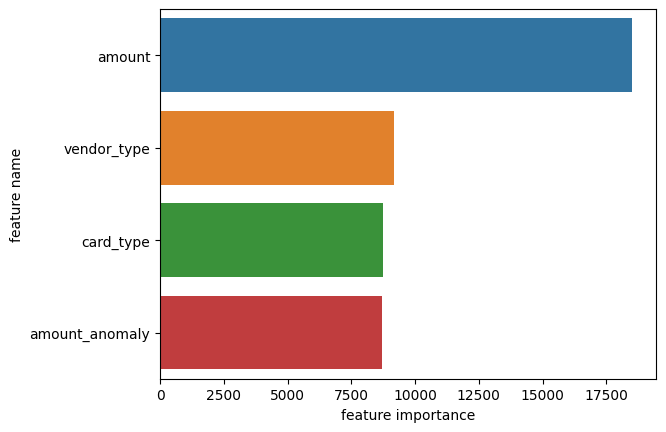

In [53]:
feature_importance = pd.DataFrame({'feature importance': model.feature_importances_, 'feature name': model.feature_name_}).sort_values(by='feature importance', ascending=False)
sns.barplot(feature_importance, y='feature name', x='feature importance')

In [54]:
with open('/kaggle/working/model_super_short_list.pickle', 'wb') as f:
    pickle.dump(model, f)